### INFO284 Machine Learning Exam, spring 2024

#### Importing and versioncontrol for relevant libraries

In [413]:
import sys
print("Python version: {}".format(sys.version))
import pandas as pd
print("pandas version: {}".format(pd.__version__))
import matplotlib
print("matplotlib version: {}".format(matplotlib.__version__))
import numpy as np
print("NumPy version: {}".format(np.__version__))
import scipy as sp
print("SciPy version: {}".format(sp.__version__))
import IPython
print("IPython version: {}".format(IPython.__version__))
import sklearn
print("scikit-learn version: {}".format(sklearn.__version__))

Python version: 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]
pandas version: 2.1.1
matplotlib version: 3.7.2
NumPy version: 1.25.2
SciPy version: 1.11.2
IPython version: 8.12.0
scikit-learn version: 1.3.1


In [414]:
import pandas as pd
filePath = 'elektronisk-rapportering-ers-2018-fangstmelding-dca-simple.csv'
#keep in mind that the file is encoded in UTF-8, so it will only work if you have the correct version of pandas.
df = pd.read_csv(filePath, encoding="UTF-8" , delimiter=";")
print(df.isna().sum())
df.head()


Melding ID                       0
Meldingstidspunkt                0
Meldingsdato                     0
Meldingsklokkeslett              0
Starttidspunkt                   0
Startdato                        0
Startklokkeslett                 0
Startposisjon bredde             0
Startposisjon lengde             0
Hovedområde start (kode)      2001
Hovedområde start             4124
Lokasjon start (kode)         2001
Havdybde start                   0
Stopptidspunkt                   0
Stoppdato                        0
Stoppklokkeslett                 0
Varighet                         0
Fangstår                         0
Stopposisjon bredde              0
Stopposisjon lengde              0
Hovedområde stopp (kode)      1962
Hovedområde stopp             4124
Lokasjon stopp (kode)         1962
Havdybde stopp                   0
Trekkavstand                    24
Redskap FAO (kode)               0
Redskap FAO                    188
Redskap FDIR (kode)            188
Redskap FDIR        

,Melding ID,Meldingstidspunkt,Meldingsdato,Meldingsklokkeslett,Starttidspunkt,Startdato,Startklokkeslett,Startposisjon bredde,Startposisjon lengde,Hovedområde start (kode),...,Art - FDIR,Art - gruppe (kode),Art - gruppe,Rundvekt,Lengdegruppe (kode),Lengdegruppe,Bruttotonnasje 1969,Bruttotonnasje annen,Bredde,Fartøylengde
0,1497177,01.01.2018,01.01.2018,00:00,31.12.2017,31.12.2017,00:00,"-60,35","-46,133",NaN,...,Antarktisk krill,506.0,Antarktisk krill,706714.0,5.0,28 m og over,9432.0,NaN,"19,87","133,88"
1,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,...,Hyse,202.0,Hyse,9594.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"
2,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,...,Torsk,201.0,Torsk,8510.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"
3,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,...,Blåkveite,301.0,Blåkveite,196.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"
4,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,...,Sei,203.0,Sei,134.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"


In [415]:
#excluding columns not relevant for our features
df = df[['Melding ID','Art - gruppe','Meldingsdato','Starttidspunkt','Havdybde start','Havdybde stopp','Rundvekt', "Art - FDIR", 'Hovedområde start', 'Hovedart FAO', 'Trekkavstand']]
df.head()
#taking note of the coloumns with missing values
print("Number of rows: ", df.shape[0])

Number of rows:  305434


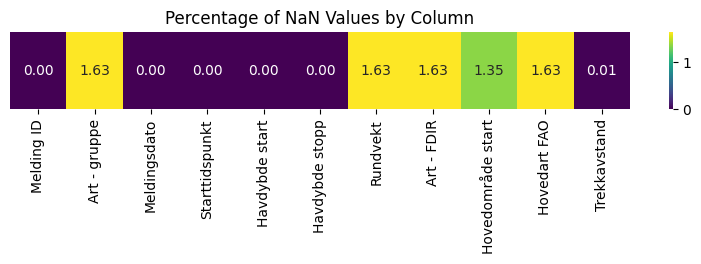

In [416]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Calculate the percentage of NaNs for each column
nanPercentage = df.isna().mean() * 100

nanPercentageDf = pd.DataFrame(nanPercentage.values.reshape(1, -1), columns=df.columns)

# Plotting the heatmap
plt.figure(figsize=(10, 1)) 
sns.heatmap(nanPercentageDf, annot=True, fmt=".2f", cmap="viridis", cbar=True)
plt.title("Percentage of NaN Values by Column")
plt.yticks([])

plt.show()

#this is for looking at the nanvalues in the dataset and how much of the dataset is missing of our specific columns. 

In [417]:
#checking every column for missing values and nan values
#print(df.isnull().sum())
print(df.isna().sum(), "\n")
print(df.isnull().sum())
#the 0 values and nan values are being counted the same as the nan values. So it wont be any collissions between the two. Assuming I can safely remove them

#removing the rows with missing values
df = df.dropna()
df.info()
print(df.isna().sum())
df.head()
print("Number of rows: ", df.shape[0])
df.head()

Melding ID              0
Art - gruppe         4982
Meldingsdato            0
Starttidspunkt          0
Havdybde start          0
Havdybde stopp          0
Rundvekt             4978
Art - FDIR           4982
Hovedområde start    4124
Hovedart FAO         4978
Trekkavstand           24
dtype: int64 

Melding ID              0
Art - gruppe         4982
Meldingsdato            0
Starttidspunkt          0
Havdybde start          0
Havdybde stopp          0
Rundvekt             4978
Art - FDIR           4982
Hovedområde start    4124
Hovedart FAO         4978
Trekkavstand           24
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 296645 entries, 1 to 305433
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Melding ID         296645 non-null  int64  
 1   Art - gruppe       296645 non-null  object 
 2   Meldingsdato       296645 non-null  object 
 3   Starttidspunkt     296645 non-null  object 


,Melding ID,Art - gruppe,Meldingsdato,Starttidspunkt,Havdybde start,Havdybde stopp,Rundvekt,Art - FDIR,Hovedområde start,Hovedart FAO,Trekkavstand
1,1497178,Hyse,01.01.2018,30.12.2017 23:21,-335,-334,9594.0,Hyse,Bjørnøya,Hyse,3970.0
2,1497178,Torsk,01.01.2018,30.12.2017 23:21,-335,-334,8510.0,Torsk,Bjørnøya,Hyse,3970.0
3,1497178,Blåkveite,01.01.2018,30.12.2017 23:21,-335,-334,196.0,Blåkveite,Bjørnøya,Hyse,3970.0
4,1497178,Sei,01.01.2018,30.12.2017 23:21,-335,-334,134.0,Sei,Bjørnøya,Hyse,3970.0
5,1497178,Hyse,01.01.2018,31.12.2017 05:48,-403,-277,9118.0,Hyse,Bjørnøya,Hyse,11096.0


In [418]:
#counting total values of art gruppe
print(df['Art - gruppe'].value_counts() , "\n")
#counting total values of art fdir
print(df['Art - FDIR'].value_counts())

Art - gruppe
Torsk                                       56145
Annen torskefisk                            45078
Sei                                         42359
Hyse                                        38831
Annen flatfisk, bunnfisk og dypvannsfisk    25141
Uer                                         19634
Steinbiter                                  16038
Dypvannsreke                                13365
Blåkveite                                    8036
Sild, annen                                  5741
Snøkrabbe                                    5270
Skater og annen bruskfisk                    4037
Makrell                                      2992
Kolmule                                      2729
Øyepål                                       2209
Annen pelagisk fisk                          1760
Vassild og strømsild                         1650
Andre skalldyr, bløtdyr og pigghuder         1263
Lodde                                        1182
Tobis og annen sil                   

In [419]:
#finding out the difference between Art- gruppe and Art - FDIR
print(df['Art - gruppe'].unique(), "\n")
print(df['Art - FDIR'].unique())


['Hyse' 'Torsk' 'Blåkveite' 'Sei' 'Steinbiter'
 'Annen flatfisk, bunnfisk og dypvannsfisk' 'Uer' 'Snøkrabbe'
 'Annen torskefisk' 'Andre skalldyr, bløtdyr og pigghuder' 'Dypvannsreke'
 'Skater og annen bruskfisk' 'Øyepål' 'Brunalger' 'Haifisk' 'Kystbrisling'
 'Sild, annen' 'Makrell' 'Vassild og strømsild' 'Kolmule'
 'Annen pelagisk fisk' 'Lodde' 'Sjøpattedyr' 'Mesopelagisk fisk'
 'Tunfisk og tunfisklignende arter' 'Taskekrabbe' 'Tobis og annen sil'
 'Raudåte' 'Kongekrabbe, annen'] 

['Hyse' 'Torsk' 'Blåkveite' 'Sei' 'Flekksteinbit' 'Kveite' 'Snabeluer'
 'Uer (vanlig)' 'Rødspette' 'Snøkrabbe' 'Lange' 'Blåsteinbit' 'Breiflabb'
 'Akkar' 'Hvitting' 'Lysing' 'Brosme' 'Annen marin fisk' 'Steinbiter'
 'Dypvannsreke' 'Skate, uspes.' 'Reke av  Pandalusslekten' 'Øyepål'
 'Smørflyndre' 'Stortare' 'Annen skate og rokke' 'Lyr' 'Sjøkreps'
 'Vanlig ti-armet blekksprut, uspes.' 'Pigghå' 'Pink cusk-eel *'
 'Glassvar' 'Brisling' 'Isgalt' 'Gråsteinbit' 'Storskate' 'Sild'
 'Blålange' 'Skater, uspes.' 'Anne

In [420]:
#checking if other will be overrepresented in the dataset
other_sum = df[~df['Art - gruppe'].isin(['Torsk', 'Sei', 'Hyse'])].shape[0]
print("Sum of others: ", other_sum)
#counting torsk sei and hyse
print(df['Art - gruppe'].value_counts())
#it definitely will be overrepresented in the dataset. Do we want to remove it? It will certainly add model complexity.

Sum of others:  159310
Art - gruppe
Torsk                                       56145
Annen torskefisk                            45078
Sei                                         42359
Hyse                                        38831
Annen flatfisk, bunnfisk og dypvannsfisk    25141
Uer                                         19634
Steinbiter                                  16038
Dypvannsreke                                13365
Blåkveite                                    8036
Sild, annen                                  5741
Snøkrabbe                                    5270
Skater og annen bruskfisk                    4037
Makrell                                      2992
Kolmule                                      2729
Øyepål                                       2209
Annen pelagisk fisk                          1760
Vassild og strømsild                         1650
Andre skalldyr, bløtdyr og pigghuder         1263
Lodde                                        1182
Tobis og annen

In [421]:
#counting number of rows
print("Number of rows: ", df.shape[0])
#realising that i havent dropped any rows since the number of rows are still the same
df.dropna(inplace=True)
print("New number of rows: ", df.shape[0])
#actually gonna drop all rows other than torsk, sei, hyse. Since we are only interested in these three species. The other are underrepresented and not relevant for our analysis.
df = df[df['Art - gruppe'].isin(['Torsk', 'Sei', 'Hyse'])]
print("Only focusing on torsk sei hyse: ", df.shape[0])
df.head()
#so now we are working with %{df}.


Number of rows:  296645
New number of rows:  296645
Only focusing on torsk sei hyse:  137335


,Melding ID,Art - gruppe,Meldingsdato,Starttidspunkt,Havdybde start,Havdybde stopp,Rundvekt,Art - FDIR,Hovedområde start,Hovedart FAO,Trekkavstand
1,1497178,Hyse,01.01.2018,30.12.2017 23:21,-335,-334,9594.0,Hyse,Bjørnøya,Hyse,3970.0
2,1497178,Torsk,01.01.2018,30.12.2017 23:21,-335,-334,8510.0,Torsk,Bjørnøya,Hyse,3970.0
4,1497178,Sei,01.01.2018,30.12.2017 23:21,-335,-334,134.0,Sei,Bjørnøya,Hyse,3970.0
5,1497178,Hyse,01.01.2018,31.12.2017 05:48,-403,-277,9118.0,Hyse,Bjørnøya,Hyse,11096.0
6,1497178,Torsk,01.01.2018,31.12.2017 05:48,-403,-277,6651.0,Torsk,Bjørnøya,Hyse,11096.0


In [422]:

#comparing art-gruppe and art-fdir to see if they are the same, counting the values
print(df['Art - gruppe'].value_counts(), "\n")
print(df['Art - FDIR'].value_counts())
#they are the same, so we can remove one of the columns.
#removing fdir
df = df.drop(columns=['Art - FDIR'])
df.head()

Art - gruppe
Torsk    56145
Sei      42359
Hyse     38831
Name: count, dtype: int64 

Art - FDIR
Torsk    56145
Sei      42359
Hyse     38831
Name: count, dtype: int64


,Melding ID,Art - gruppe,Meldingsdato,Starttidspunkt,Havdybde start,Havdybde stopp,Rundvekt,Hovedområde start,Hovedart FAO,Trekkavstand
1,1497178,Hyse,01.01.2018,30.12.2017 23:21,-335,-334,9594.0,Bjørnøya,Hyse,3970.0
2,1497178,Torsk,01.01.2018,30.12.2017 23:21,-335,-334,8510.0,Bjørnøya,Hyse,3970.0
4,1497178,Sei,01.01.2018,30.12.2017 23:21,-335,-334,134.0,Bjørnøya,Hyse,3970.0
5,1497178,Hyse,01.01.2018,31.12.2017 05:48,-403,-277,9118.0,Bjørnøya,Hyse,11096.0
6,1497178,Torsk,01.01.2018,31.12.2017 05:48,-403,-277,6651.0,Bjørnøya,Hyse,11096.0


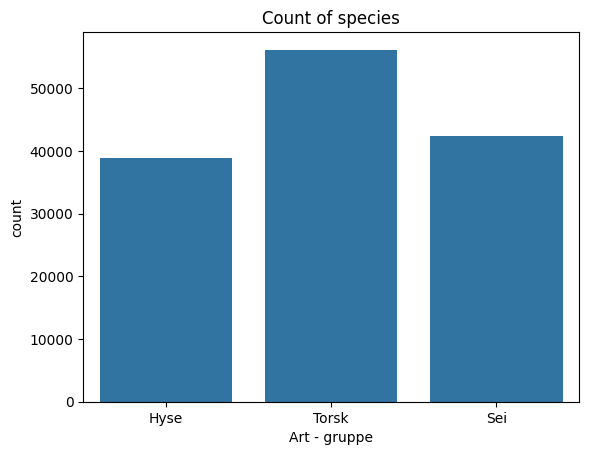

In [423]:
#presenting the count of the different species in the dataset with a barplot
sns.countplot(x='Art - gruppe', data=df)
plt.title('Count of species')
plt.show()

In [424]:
#counting the unique number of boats
print(df['Melding ID'].unique())

[1497178 1497229 1497288 ... 1800285 1800286 1800291]


<Axes: xlabel='Havdybde start', ylabel='Havdybde stopp'>

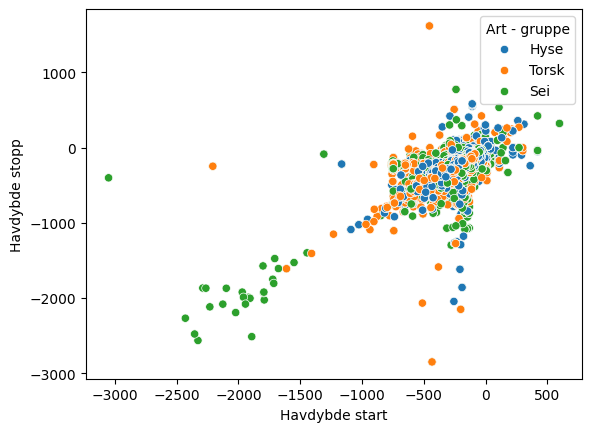

In [425]:
#plotting havdybde start and havdybde stopp using seaborn with different color for each species
sns.scatterplot(x='Havdybde start', y='Havdybde stopp', data=df, hue='Art - gruppe')
#viewing the plot and seeing it is so dense that it is hard to see the differences between the species. Additionally there are a lot of species over 0 which does not make sense when fishing.

#maybe we should use a threshold for the depth, since it is not possible to fish at 0 depth?
#then we will loose a lot of data points, so maybe there is a way to transform the outliers?
#But then again the transformed outliers will be useless since the initial values are not reliable? Are depth feature even reliable?


#note: Should probably transform the Art-gruppe to numerical values with one hot encoding.

In [426]:
#pivoting the rows where all the meldingspunkt are identical on the same row including all the species
df = df.pivot_table(index=['Melding ID', 'Meldingsdato', 'Starttidspunkt', 'Havdybde start', 'Havdybde stopp','Hovedområde start', 'Hovedart FAO', 'Trekkavstand'], columns='Art - gruppe', values='Rundvekt', aggfunc='sum').reset_index()
df = df.fillna(0) # filling Nan values with 0
print("Number of rows: ", df.shape[0])
df.head(15)


Number of rows:  65105


Art - gruppe,Melding ID,Meldingsdato,Starttidspunkt,Havdybde start,Havdybde stopp,Hovedområde start,Hovedart FAO,Trekkavstand,Hyse,Sei,Torsk
0,1497178,01.01.2018,30.12.2017 23:21,-335,-334,Bjørnøya,Hyse,3970.0,9594.0,134.0,8510.0
1,1497178,01.01.2018,31.12.2017 05:48,-403,-277,Bjørnøya,Hyse,11096.0,9118.0,67.0,6651.0
2,1497178,01.01.2018,31.12.2017 11:34,-346,-496,Bjørnøya,Hyse,10215.0,12432.0,68.0,5097.0
3,1497178,01.01.2018,31.12.2017 17:44,-443,-358,Bjørnøya,Torsk,3214.0,6758.0,0.0,7022.0
4,1497229,01.01.2018,01.01.2018 10:01,-71,-56,Røstbanken til Malangsgrunnen,Hyse,1269.0,4.0,0.0,0.0
5,1497229,01.01.2018,01.01.2018 13:07,-71,-54,Røstbanken til Malangsgrunnen,Torsk,1471.0,0.0,0.0,1800.0
6,1497288,01.01.2018,01.01.2018 05:47,-1090,-1090,Røstbanken til Malangsgrunnen,Sei,0.0,54.0,2895.0,2100.0
7,1497306,01.01.2018,01.01.2018 07:00,-298,-293,Nordkappbanken,Torsk,371.0,2257.0,0.0,8371.0
8,1497310,01.01.2018,01.01.2018 07:09,-139,-145,Shetland,Lange,23342.0,0.0,240.0,106.0
9,1497310,01.01.2018,01.01.2018 12:04,-148,-153,Shetland,Lange,21053.0,0.0,96.0,35.0


#### Current thoughts:
How will we treat outliers and all above 0 depth?

In [427]:
#instead of removing rows with depth 0 we instead flip them all to minus integers, since they are probably missing it.
df['Havdybde start'] = -df['Havdybde start'].abs() #using abs with minus will negate the absolute number
df['Havdybde stopp'] = -df['Havdybde stopp'].abs()
df['Trekkavstand'] = -df['Trekkavstand'].abs()
#removing all rows where the depth is greater than -1  this turned out to be irrelevant
# df = df[df['Havdybde start'] <= -1]
# df = df[df['Havdybde stopp'] <= -1]

#now counting the number of rows
print("Number of rows: ", df.shape[0])
df.info()
df.head()

Number of rows:  65105
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65105 entries, 0 to 65104
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Melding ID         65105 non-null  int64  
 1   Meldingsdato       65105 non-null  object 
 2   Starttidspunkt     65105 non-null  object 
 3   Havdybde start     65105 non-null  int64  
 4   Havdybde stopp     65105 non-null  int64  
 5   Hovedområde start  65105 non-null  object 
 6   Hovedart FAO       65105 non-null  object 
 7   Trekkavstand       65105 non-null  float64
 8   Hyse               65105 non-null  float64
 9   Sei                65105 non-null  float64
 10  Torsk              65105 non-null  float64
dtypes: float64(4), int64(3), object(4)
memory usage: 5.5+ MB


Art - gruppe,Melding ID,Meldingsdato,Starttidspunkt,Havdybde start,Havdybde stopp,Hovedområde start,Hovedart FAO,Trekkavstand,Hyse,Sei,Torsk
0,1497178,01.01.2018,30.12.2017 23:21,-335,-334,Bjørnøya,Hyse,-3970.0,9594.0,134.0,8510.0
1,1497178,01.01.2018,31.12.2017 05:48,-403,-277,Bjørnøya,Hyse,-11096.0,9118.0,67.0,6651.0
2,1497178,01.01.2018,31.12.2017 11:34,-346,-496,Bjørnøya,Hyse,-10215.0,12432.0,68.0,5097.0
3,1497178,01.01.2018,31.12.2017 17:44,-443,-358,Bjørnøya,Torsk,-3214.0,6758.0,0.0,7022.0
4,1497229,01.01.2018,01.01.2018 10:01,-71,-56,Røstbanken til Malangsgrunnen,Hyse,-1269.0,4.0,0.0,0.0


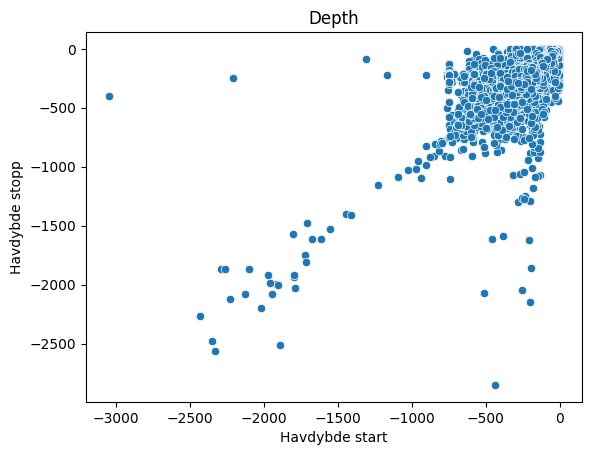

Art - gruppe,Melding ID,Meldingsdato,Starttidspunkt,Havdybde start,Havdybde stopp,Hovedområde start,Hovedart FAO,Trekkavstand,Hyse,Sei,Torsk,Dominant Art
0,1497178,01.01.2018,30.12.2017 23:21,-335,-334,Bjørnøya,Hyse,-3970.0,9594.0,134.0,8510.0,Hyse
1,1497178,01.01.2018,31.12.2017 05:48,-403,-277,Bjørnøya,Hyse,-11096.0,9118.0,67.0,6651.0,Hyse
2,1497178,01.01.2018,31.12.2017 11:34,-346,-496,Bjørnøya,Hyse,-10215.0,12432.0,68.0,5097.0,Hyse
3,1497178,01.01.2018,31.12.2017 17:44,-443,-358,Bjørnøya,Torsk,-3214.0,6758.0,0.0,7022.0,Torsk
4,1497229,01.01.2018,01.01.2018 10:01,-71,-56,Røstbanken til Malangsgrunnen,Hyse,-1269.0,4.0,0.0,0.0,Hyse


In [428]:
#plotting depth, it now works correctly with negated integers.
sns.scatterplot(x='Havdybde start', y='Havdybde stopp', data=df)
plt.title('Depth')
plt.show()

# Get the name of the category with the max value in the Dominant Art row
df['Dominant Art'] = df[['Hyse', 'Sei', 'Torsk']].idxmax(axis=1) # idmax will also return the first occurence of the max value
df.head()

#### Trying a model

##### Predicting what the main intended catch is based on the largest rundvekt values.

In [429]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split the data into training and testing sets
X = df[['Hyse', 'Sei', 'Torsk']]
y = df['Hovedart FAO']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

# Evaluate the model
accuracy = knn.score(X_test_scaled, y_test)
print("Accuracy:", accuracy)


Accuracy: 0.8303509715075647


#### Trying to predict hyse sei torsk based on depth, this did not really work due to the values for the species are large float values.

In [430]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier
#using knn to predict the fish species based on depth
# Step 1: Prepare the data
X = df[['Havdybde start', 'Havdybde stopp']]
y = df[['Hyse', 'Sei', 'Torsk']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=5)
classifier = MultiOutputClassifier(knn, n_jobs=-1) #have to use multioutputclassifier since we have multiple outputs
classifier.fit(X_train_scaled, y_train)

y_pred = classifier.predict(X_test_scaled)

accuracy = classifier.score(X_test_scaled, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.0006911911527532448


#### Trying to predict dominant art based on dybde features

In [431]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier
#using knn to predict the fish species based on depth
# Step 1: Prepare the data
X = df[['Havdybde start', 'Havdybde stopp']]
y = df[['Dominant Art']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)

accuracy = knn.score(X_test_scaled, y_test)
print("Accuracy:", accuracy)

C:\Users\brohn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Accuracy: 0.4936640810997619


#### Adding one hot encoded values

In [432]:
#converting Dominant Art column to one hot encoded values
dfEncoded = pd.get_dummies(df, columns=['Dominant Art'])
dfEncoded.head()

,Melding ID,Meldingsdato,Starttidspunkt,Havdybde start,Havdybde stopp,Hovedområde start,Hovedart FAO,Trekkavstand,Hyse,Sei,Torsk,Dominant Art_Hyse,Dominant Art_Sei,Dominant Art_Torsk
0,1497178,01.01.2018,30.12.2017 23:21,-335,-334,Bjørnøya,Hyse,-3970.0,9594.0,134.0,8510.0,True,False,False
1,1497178,01.01.2018,31.12.2017 05:48,-403,-277,Bjørnøya,Hyse,-11096.0,9118.0,67.0,6651.0,True,False,False
2,1497178,01.01.2018,31.12.2017 11:34,-346,-496,Bjørnøya,Hyse,-10215.0,12432.0,68.0,5097.0,True,False,False
3,1497178,01.01.2018,31.12.2017 17:44,-443,-358,Bjørnøya,Torsk,-3214.0,6758.0,0.0,7022.0,False,False,True
4,1497229,01.01.2018,01.01.2018 10:01,-71,-56,Røstbanken til Malangsgrunnen,Hyse,-1269.0,4.0,0.0,0.0,True,False,False


#### Predicting with one hot encoded values and multioutput values

In [433]:
#trying to predict the dominant art based on the depth again with one hot encoded values
X = dfEncoded[['Havdybde start', 'Havdybde stopp', 'Trekkavstand']]
y = dfEncoded[['Dominant Art_Hyse', 'Dominant Art_Sei', 'Dominant Art_Torsk']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=5)

classifier = MultiOutputClassifier(knn, n_jobs=-1)
classifier.fit(X_train_scaled, y_train)

y_pred = classifier.predict(X_test_scaled)

accuracy = classifier.score(X_test_scaled, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.4741571307887259


In [434]:
#checking the number of instances of each species
print(df['Dominant Art'].value_counts())
# 

Dominant Art
Torsk    29798
Sei      26151
Hyse      9156
Name: count, dtype: int64


#### Predicting only one target(Hyse) which is a one hot encoded value, based on depth

In [435]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier
# Step 1: Prepare the data
X = dfEncoded[['Havdybde start', 'Havdybde stopp', 'Trekkavstand']]
y = dfEncoded[['Dominant Art_Hyse']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=1)
# classifier = MultiOutputClassifier(knn, n_jobs=-1)
knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)

accuracy = knn.score(X_test_scaled, y_test)
print("Accuracy:", accuracy)

C:\Users\brohn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Accuracy: 0.8100760310268028


In [436]:
#grouped = dfNew.groupby(['Melding ID', 'Meldingsdato', 'Starttidspunkt'])
#print(dfNew.grouped.size())

#realsing that the same boat is fishing further down in dataset, so we have to group differently.
#looking if the same boat gets a new id if its fishing again
""" print(dfNew['Melding ID'].value_counts(),"\n") """
#checking in old dataset
""" print(df['Melding ID'].value_counts()) """
#checking the unique values of the Melding ID in the old dataset
""" print(df['Melding ID'].nunique()) """
#this means its 4937 unique boats in the dataset
#I want to check if the same boat gets a new id if its fishing again
#checking the whole dataset
print(df['Melding ID'].value_counts())
""" Melding ID
1657367    54
1646724    50
1654624    46
1601430    44
1695415    44 """  
#this tells me it keeps the same id
#But then we would have to group by Melding ID, and Start


Melding ID
1638927    9
1687068    9
1793849    9
1654624    9
1737106    9
          ..
1698671    1
1698670    1
1698618    1
1698607    1
1691752    1
Name: count, Length: 34286, dtype: int64


' Melding ID\n1657367    54\n1646724    50\n1654624    46\n1601430    44\n1695415    44 '

In [437]:
#rows where Melding ID, Starttidspunkt are identical it's actually the same boat just casting different lines from the fishingboat
#We would have to transform data to represent the sameboat on a single row
#Each row with the same mentioned columns, are representing each row with a different fish. So they use rows to represent the same boat, but different fish
""" grouped = df.groupby(['Melding ID', 'Starttidspunkt', 'Startklokkeslett'])
print(grouped.size()) """
#realising its enough to group by Meldings ID
#grouped = df.groupby(['Melding ID', 'Meldingsdato','Starttidspunkt'])
#print(grouped.size())

#now I would have to aggregate the data where the size is greater than 1 into a single row, but also represent all the different fish in the same row
#Since the fish are in each of their own rows orginally, The new row would have to represent all the fish in the same row, with each fish in their own column
#I would have to use the pivot function to do this?  Trying with pivot


#now I want to aggregate the data where the size is greater than 1 into a single row
#code for this would be
aggFunctions = {'Melding ID':'first','Starttidspunkt':'first', 'Meldingsdato':'first', 'Art - gruppe':'first', 'Havdybde start':'first', 'Havdybde stopp':'first', 'Rundvekt':'sum', 'Art - FDIR':'first'}

#dfNew = df.groupby(['Melding ID', 'Starttidspunkt']).agg(aggFunctions)
#transforming each group into a single row
#print(dfNew.head())

""" aggFunctions = {'Melding ID':'first','Starttidspunkt':'first', 'Meldingsdato':'first', 'Art - gruppe':'first', 'Havdybde start':'first', 'Havdybde stopp':'first', 'Rundvekt':'sum', 'Art - FDIR':'first'}

dfNew = df.groupby('Melding ID','Starttidspunkt').agg(aggFunctions)
#transforming each group into a single row
print(dfNew.head()) """

" aggFunctions = {'Melding ID':'first','Starttidspunkt':'first', 'Meldingsdato':'first', 'Art - gruppe':'first', 'Havdybde start':'first', 'Havdybde stopp':'first', 'Rundvekt':'sum', 'Art - FDIR':'first'}\n\ndfNew = df.groupby('Melding ID','Starttidspunkt').agg(aggFunctions)\n#transforming each group into a single row\nprint(dfNew.head()) "